In [2]:
from tqdm import tqdm_notebook as tqdm
import numpy as np
import scipy.linalg as lin

import matplotlib.pyplot as plt
plt.style.use(['dark_background'])

import statsmodels.tsa.stattools as st

# Rescaled ZZ process for infinite dimensional Gaussian distribution

In [3]:
def next_refresh_time(lambda_refresh, Z):
    return Z/lambda_refresh

def next_bounce_time_gaussian_coordinate(x, v, C, k, Z):
    A = v[k]*x[k]/C[k,k]
    B = v[k]*v[k]/C[k,k]
    T0 = np.maximum(0.0, -A/B)
        
    tau = (-A + np.sqrt(A*A + 2*A*B*T0 + B*B*T0*T0 + 2*B*Z))/B
    
    return tau
  
def zz_gaussian(C, x0, v0, T, num_samples):
    d = x0.shape[0]
    
    sample_mesh  = np.linspace(0, T, num_samples)

    t = 0.0

    reflect_count = 0
    
    x_sample = np.zeros((len(sample_mesh), d))
    v_sample = np.zeros((len(sample_mesh), d))
    t_sample = np.zeros(len(sample_mesh))
    num_reflect = np.zeros(len(sample_mesh))

    erg_av  = 0.0
    erg_var = 0.0

    sample_index = 0
    
    x = x0
    v = v0
    
    #progress bar code
    pbar = tqdm(total=num_samples)

    taus_ng = np.zeros(d)
    taus_g = np.zeros(d)

    while (t < T):   
        
        #Calculate next bounce times

        tau_min = np.inf
        for k in range(d):
            taus_g[k] = next_bounce_time_gaussian_coordinate(x, v, C, k, -np.log(np.random.rand()))
            
            if (taus_g[k] < tau_min):
                k_min = k
                tau_min = taus_g[k]
        
                
        #Generate the ergodic averages
        erg_av = erg_av + x*tau_min + 0.5*v*tau_min**2
        erg_var = erg_var +  x*x*tau_min + v*x*tau_min**2 + (1.0/3)*v*v*tau_min**3
        
        
        #Generate the regular sample of x, v, t along the trajectory
        while ((sample_index < num_samples) and (t + tau_min > sample_mesh[sample_index])):

            #print("%d : %2.12f, %2.12f"%(sample_index, t, tau_min))
            x_sample[sample_index,:] = x + (sample_mesh[sample_index] - t)*v
            v_sample[sample_index, :] = v
            t_sample[sample_index] = t
            
            num_reflect[sample_index] = reflect_count
            
            reflect_count = 0
            sample_index = sample_index + 1
            pbar.update(1)
                 
        reflect_count = reflect_count + 1
        
        
        t = t + tau_min
        x = x + tau_min*v
        
        v[k_min] = -v[k_min]
        
    erg_av = erg_av/t
    erg_var = erg_var/t - (erg_av)**2
    
    pbar.close()
    
    return(erg_av, erg_var, x_sample, v_sample, t_sample, num_reflect)

In [6]:
def compute_errors(erg_av, erg_var,x_sample, C):
    Cinv=lin.inv(C)
    av_err = np.linalg.norm(erg_av)
    var_err = np.linalg.norm(erg_var - np.diag(C))
    cv_err = np.mean(np.abs(np.mean((Cinv @ x_sample.T).T, 0)))
    
    return (av_err, var_err, cv_err)
    
def run_experiment(d, alpha, burnin, fname):
    C = np.diag([1.0/(i+1)**2 for i in np.arange(d)])
    x0 = np.zeros(d)
    v0 = 1.0/np.arange(1, d+1)**alpha
    
    #T = 100000.0
    T = 1000.0
    num_samples = int(T)

    erg_av, erg_var, x_sample, v_sample, t_sample, reflect_count_zz = zz_gaussian(C, x0, v0, T, num_samples)
    av_err, var_err,cv_err = compute_errors(erg_av, erg_var,x_sample, C)
        
    x_sample=x_sample[burnin:,:]
    reflect_count_zz= reflect_count_zz[burnin:]
    
    plt.subplot(2,2,1)
    plt.plot(np.cumsum(x_sample[:,0])/np.arange(1, 1+ x_sample.shape[0]))

    plt.subplot(2,2,2)
    plt.plot(np.cumsum(reflect_count_zz)/np.arange(1, 1+ len(reflect_count_zz)))

    plt.subplot(2,2,3)
    plt.plot(st.acf(x_sample[:,0],unbiased=True))

    plt.suptitle("d = %d, eta = %1.2f, av_err = %f, var_err = %f"%(d, alpha, av_err, var_err))
    plt.tight_layout()
    plt.savefig(fname+".png",dpi=199)
    
    np.savetxt(fname+".txt", (d, alpha, av_err, var_err, cv_err, np.mean(reflect_count_zz)))
    
    
    plt.clf()

In [7]:
run_experiment(10, 1.0, 500,"figures/zz_0");

<Figure size 432x288 with 0 Axes>

In [488]:
run_experiment(1, 0.0, 500,"figures/zz1_0");
run_experiment(1, 1.0, 500,"figures/zz1_1");
run_experiment(1, 2.0, 500,"figures/zz1_2");
run_experiment(1, 3.0, 500,"figures/zz1_3");
run_experiment(1, 4.0, 500,"figures/zz1_4");

run_experiment(10, 0.0, 500,"figures/zz2_0");
run_experiment(10, 1.0, 500, "figures/zz2_1");
run_experiment(10, 2.0, 500, "figures/zz2_2");
run_experiment(10, 3.0, 500, "figures/zz2_3");
run_experiment(10, 4.0, 500, "figures/zz2_4");

run_experiment(20, 0.0, 500, "figures/zz3_0");
run_experiment(20, 1.0, 500, "figures/zz3_1");
run_experiment(20, 2.0, 500, "figures/zz3_2");
run_experiment(20, 3.0, 500, "figures/zz3_3");
run_experiment(20, 4.0, 500, "figures/zz3_4");

run_experiment(30, 0.0, 500, "figures/zz4_0");
run_experiment(30, 1.0, 500, "figures/zz4_1");
run_experiment(30, 2.0, 500, "figures/zz4_2");
run_experiment(30, 3.0, 500, "figures/zz4_3");
run_experiment(30, 4.0, 500, "figures/zz4_4");

run_experiment(40, 0.0, 500, "figures/zz5_0");
run_experiment(40, 1.0, 500, "figures/zz5_1");
run_experiment(40, 2.0, 500, "figures/zz5_2");
run_experiment(40, 3.0, 500, "figures/zz5_3");
run_experiment(40, 4.0, 500, "figures/zz5_4");

run_experiment(50, 0.0, 500, "figures/zz6_0");
run_experiment(50, 1.0, 500, "figures/zz6_1");
run_experiment(50, 2.0, 500, "figures/zz6_2");
run_experiment(50, 3.0, 500, "figures/zz6_3");
run_experiment(50, 4.0, 500, "figures/zz6_4");

run_experiment(60, 0.0, 500, "figures/zz7_0");
run_experiment(60, 1.0, 500, "figures/zz7_1");
run_experiment(60, 2.0, 500, "figures/zz7_2");
run_experiment(60, 3.0, 500, "figures/zz7_3");
run_experiment(60, 4.0, 500, "figures/zz7_4");

run_experiment(70, 0.0, 500, "figures/zz8_0");
run_experiment(70, 1.0, 500, "figures/zz8_1");
run_experiment(70, 2.0, 500, "figures/zz8_2");
run_experiment(70, 3.0, 500, "figures/zz8_3");
run_experiment(70, 4.0, 500, "figures/zz8_4");

run_experiment(80, 0.0, 500, "figures/zz9_0");
run_experiment(80, 1.0, 500, "figures/zz9_1");
run_experiment(80, 2.0, 500, "figures/zz9_2");
run_experiment(80, 3.0, 500, "figures/zz9_3");
run_experiment(80, 4.0, 500, "figures/zz9_4");

run_experiment(90, 0.0, 500, "figures/zz10_0");
run_experiment(90, 1.0, 500, "figures/zz10_1");
run_experiment(90, 2.0, 500, "figures/zz10_2");
run_experiment(90, 3.0, 500, "figures/zz10_3");
run_experiment(90, 4.0, 500, "figures/zz10_4");


run_experiment(100, 0.0, 500, "figures/zz11_0");
run_experiment(100, 1.0, 500, "figures/zz11_1");
run_experiment(100, 2.0, 500, "figures/zz11_2");
run_experiment(100, 3.0, 500, "figures/zz11_3");
run_experiment(100, 4.0, 500, "figures/zz11_4");


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [482]:
import glob
simulation_table = []
for fname in glob.glob('figures/zz*.txt', recursive=True):
    x = np.loadtxt(fname)
    simulation_table = simulation_table + [x]
    
simulation_table = np.vstack(simulation_table)
simulation_table = simulation_table[simulation_table[:,0].argsort()]

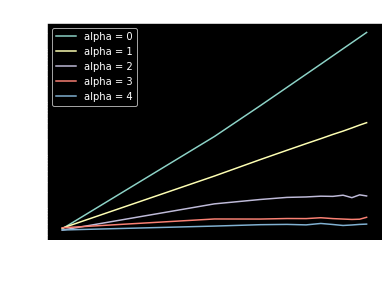

In [492]:
series = simulation_table[simulation_table[:,1]==0.0,:]
plt.loglog(series[:,0], series[:,5], label='alpha = 0')

series = simulation_table[simulation_table[:,1]==1.0,:]
plt.loglog(series[:,0], series[:,5], label='alpha = 1')

series = simulation_table[simulation_table[:,1]==2.0,:]
plt.loglog(series[:,0], series[:,5], label='alpha = 2')

series = simulation_table[simulation_table[:,1]==3.0,:]
plt.loglog(series[:,0], series[:,5], label='alpha = 3')

series = simulation_table[simulation_table[:,1]==4.0,:]
plt.loglog(series[:,0], series[:,5], label='alpha = 4')

plt.legend()
plt.xlabel("dimension")
plt.ylabel("flips per unit time")
plt.title("Number of flips per unit time")
#plt.show()
plt.savefig("figures/zz_flips.png",dpi=199)

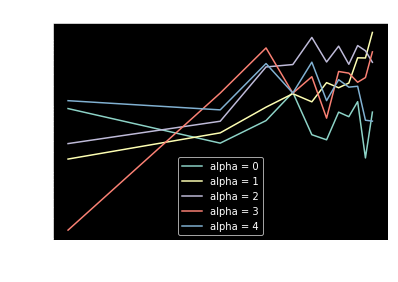

In [493]:
series = simulation_table[simulation_table[:,1]==0.0,:]
plt.loglog(series[:,0], series[:,3], label='alpha = 0')

series = simulation_table[simulation_table[:,1]==1.0,:]
plt.loglog(series[:,0], series[:,3], label='alpha = 1')

series = simulation_table[simulation_table[:,1]==2.0,:]
plt.loglog(series[:,0], series[:,3], label='alpha = 2')

series = simulation_table[simulation_table[:,1]==3.0,:]
plt.loglog(series[:,0], series[:,3], label='alpha = 3')

series = simulation_table[simulation_table[:,1]==4.0,:]
plt.loglog(series[:,0], series[:,3], label='alpha = 4')

plt.legend()

plt.xlabel("dimension")
plt.ylabel("L2 norm of variance error")
plt.title("Error in marginal variance")
#plt.show()
plt.savefig("figures/zz_error_var.png",dpi=199)

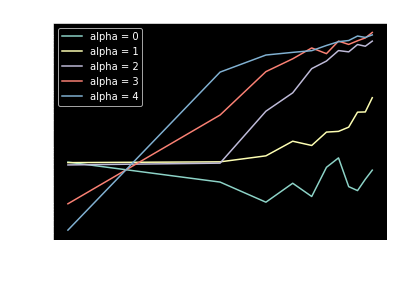

In [494]:
series = simulation_table[simulation_table[:,1]==0.0,:]
plt.loglog(series[:,0], series[:,2], label='alpha = 0')

series = simulation_table[simulation_table[:,1]==1.0,:]
plt.loglog(series[:,0], series[:,2], label='alpha = 1')

series = simulation_table[simulation_table[:,1]==2.0,:]
plt.loglog(series[:,0], series[:,2], label='alpha = 2')

series = simulation_table[simulation_table[:,1]==3.0,:]
plt.loglog(series[:,0], series[:,2], label='alpha = 3')

series = simulation_table[simulation_table[:,1]==4.0,:]
plt.loglog(series[:,0], series[:,2], label='alpha = 4')

plt.legend()

plt.xlabel("dimension")
plt.ylabel("L2 norm of mean error")
plt.title("Error in marginal mean")
#plt.show()
plt.savefig("figures/zz_error_mean.png",dpi=199)

# Infinite dimensional zig-zag

$$u(\tau) = \sqrt{2}\sum_{n}a_{n}\sin(n\pi\tau)$$ 
and
$$
    \partial_{a_k}U(a) = 2\sqrt{2}\int \left[\left(\sqrt{2}\sum_{n}a_{n}\sin(n\pi\tau)\right)^3 - \sqrt{2}\sum_{n}a_{n}\sin(n\pi\tau)\right]sin(n\pi k \tau)\,d\tau.
$$
Using Riemann sums:
$$
    \partial_{a_k}U(a) = 2\sqrt{2}\sum_i \left[\left(\sqrt{2}\sum_{n}a_{n}\sin(n\pi\tau_i)\right)^3 - \sqrt{2}\sum_{n}a_{n}\sin(n\pi\tau_i)\right]sin(n\pi k \tau_i)\,\Delta \tau.
$$

This can be rewritten as 
$$
 \partial_{a_k}U(a) = 2 \left[\left(Fa\right)^3 - Fa\right]F_{(\cdot,k)}\,\Delta \tau.
$$

So that the intensity can be written as 
$$
   \lambda_k(x+tv,v) = \left(2 v_k\left[\left(F(a+tv)\right)^3 - F(a+tv)\right]F_{(\cdot,k)}\,\Delta \tau \right)_{+}
$$
so that
$$
 \lambda_k(x+tv,v) \leq |(2(Fa)^3 - 2(Fa)) F_kv_k| + t|(6(Fa)^2(Fv) - 2(Fv))F_kv_k| + 6t^2 |(Fa)(Fv)^2 F_kv_k| + t^3|2(Fv)^3 F_k v_k|.
$$

Integrating:
$$s(T)  \leq T|(2(Fa)^3 - 2(Fa)) F_kv_k| + T^2|(3(Fa)^2(Fv) - (Fv))F_kv_k| + 2T^3 |(Fa)(Fv)^2 F_kv_k| + (1/2)T^4|(Fv)^3 F_k v_k|$$

In [450]:
R = 1.0
N = 10**2
K = 100

dx = R/N

mesh1 = np.linspace(0, R, N, endpoint=False)[1:]
Fmat = np.sqrt(2)*np.array([[np.sin(np.pi*k*m) for k in range(1, K+1)] for m in mesh1])


In [35]:
def next_refresh_time(lambda_refresh, Z):
    return Z/lambda_refresh

def intensity_non_gaussian_coordinate(x, v, tau, k, Fv, Fx, dx, Fmat):
    
    z = Fx + tau*Fv 
    s = (2.0*(z**3 - z) @ Fmat[:,k])* v[k]*dx
    
    return max(0.0, s)

def dominating_intensity_non_gaussian_coordinate(x, v, tau, k, Fv, Fx, dx, Fmat):
    Fkvk = Fmat[:, k]*v[k]
    
    T4 = np.dot(Fkvk, 2.0*(Fv)**3)*dx
    T3 = np.dot(Fkvk, 6.0*(Fv)**2 * Fx)*dx
    T2 = np.dot(Fkvk, 6.0*(Fv) * (Fx)**2 - 2.0*Fv)*dx
    T1 = 2.0*np.dot(Fkvk, (Fx)**3 - Fx)*dx
    
    return np.abs(T1) + tau*np.abs(T2) + tau*tau*np.abs(T3) + tau*tau*tau*np.abs(T4)
    
def next_bounce_time_non_gaussian_coordinate(x, v, k, Z,  Fv, Fx, dx, Fmat):
    #Assemble coefficients.
    
    Fkvk = Fmat[:, k]*v[k]
    
    T4 = 0.5*np.dot(Fkvk, (Fv)**3)
    T3 = 2.0*np.dot(Fkvk, (Fv)**2 * Fx)
    T2 = 3.0*np.dot(Fkvk, (Fv) * (Fx)**2) - np.dot(Fkvk, Fv)
    T1 = 2.0*np.dot(Fkvk, (Fx)**3 - Fx)
    
    p = [np.abs(T4)*dx, np.abs(T3)*dx, np.abs(T2)*dx, np.abs(T1)*dx, -Z]
    
    rts = np.roots(p)
  #  print(rts)

    tau = np.real(rts[-1])
    if (tau < 0):
        tau = np.inf
    
    return tau
    

def next_bounce_time_gaussian_coordinate(x, v, C, k, Z):
    A = v[k]*x[k]/C[k,k]
    B = v[k]*v[k]/C[k,k]
    T0 = np.maximum(0.0, -A/B)
        
    tau = (-A + np.sqrt(A*A + 2*A*B*T0 + B*B*T0*T0 + 2*B*Z))/B
    
    return tau
  
def zz_non_gaussian(C, x0, v0, T, num_samples, Fmat, dx):
    d = x0.shape[0]
    
    sample_mesh  = np.linspace(0, T, num_samples)

    t = 0.0

    refresh_count = 0
    reflect_count = 0
    
    x_sample = np.zeros((len(sample_mesh), d))
    v_sample = np.zeros((len(sample_mesh), d))
    t_sample = np.zeros(len(sample_mesh))
    num_reflect = np.zeros(len(sample_mesh))
    num_refresh = np.zeros(len(sample_mesh))

    erg_av  = 0.0
    erg_var = 0.0

    sample_index = 0
    
    x = x0
    v = v0
    
    #progress bar code
    pbar = tqdm(total=num_samples)

    taus_ng = np.zeros(d)
    taus_g = np.zeros(d)

    while (t < T):   
        
        #Calculate next bounce times
        Fv = Fmat @ v
        Fx = Fmat @ x
 
        tau_ng_min = np.inf
        tau_g_min = np.inf
        
        k_ng_min = -1
        k_g_min = -1
        for k in range(d):
            taus_ng[k] = next_bounce_time_non_gaussian_coordinate(x, v, k, -np.log(np.random.rand()), Fv, Fx, dx, Fmat)
            taus_g[k] = next_bounce_time_gaussian_coordinate(x, v, C, k, -np.log(np.random.rand()))
            
            if (taus_ng[k] < tau_ng_min):
                tau_ng_min = taus_ng[k]
                k_ng_min = k
                
            if (taus_g[k] < tau_g_min):
                tau_g_min = taus_g[k]
                k_g_min = k
            
        
#         print("tau_ng_min ", np.min(taus_ng), " : tau_g_min ", tau_g_min)
        tau_min = min(tau_ng_min, tau_g_min)
        
        #Generate the ergodic averages
        erg_av = erg_av + x*tau_min + 0.5*v*tau_min**2
        erg_var = erg_var +  x*x*tau_min + v*x*tau_min**2 + (1.0/3)*v*v*tau_min**3
        
        
        #Generate the regular sample of x, v, t along the trajectory
        while ((sample_index < num_samples) and (t + tau_min > sample_mesh[sample_index])):

            #print("%d : %2.12f, %2.12f"%(sample_index, t, tau_min))
            x_sample[sample_index,:] = x + (sample_mesh[sample_index] - t)*v
            v_sample[sample_index, :] = v
            t_sample[sample_index] = t
            
            num_reflect[sample_index] = reflect_count
            
            reflect_count = 0
            sample_index = sample_index + 1
            pbar.update(1)
        
        v_new = v.copy()

        if (tau_ng_min < tau_g_min):
            k = k_ng_min
            m = intensity_non_gaussian_coordinate(x, v, tau_min, k, Fv, Fx, dx, Fmat)
            M = dominating_intensity_non_gaussian_coordinate(x, v, tau_min, k, Fv, Fx, dx, Fmat)

            r = np.random.rand()
            
       #     print(tau_min, k, m, M, m/M)
            if (r <= m/M):
                v_new[k] = -v_new[k]
                reflect_count = reflect_count + 1
        else:
            k = k_g_min
            v_new[k] = -v_new[k]
            reflect_count = reflect_count + 1
        
        
        t = t + tau_min
        x = x + tau_min*v
        
        v = v_new.copy()
        
    erg_av = erg_av/t
    erg_var = erg_var/t - (erg_av)**2
    
    pbar.close()
    
    return(erg_av, erg_var, x_sample, v_sample, t_sample, num_reflect)

$$ a_i = 1/i^\alpha$$

In [ ]:
C = np.diag(np.array(1.0/(np.pi*np.arange(1, K+1))**2))
alpha = 4.0
v0 = 1.0/np.arange(1, K+1)**alpha
x0 = np.zeros(C.shape[0])

T = 10000.0
num_samples = int(T/1e-1)

erg_av_zz, erg_var_zz, x_sample_zz, v_sample_zz, t_sample_zz, reflect_count_zz = zz_non_gaussian(C, x0, v0, T, num_samples)


In [404]:
x_sample_zz_real = (Fmat @ x_sample_zz.T).T

In [42]:
def compute_errors(erg_av, erg_var,x_sample, C, dx):
    Cinv=lin.inv(C)
    av_err = np.linalg.norm(erg_av)
    cv_err = np.mean(np.abs(np.mean((Cinv@x_sample.T + 2.0*dx*((x_sample.T)**3 - x_sample.T)).T,0)))
    
    return (av_err, cv_err)
    
def run_experiment_zz_ng(N, K, alpha, burnin, fname):
    R = 1.0
    dx = R/N
    
    mesh = np.linspace(0, R, N, endpoint=False)[1:]
    C = np.diag(np.array(1.0/(np.pi*np.arange(1, K+1))**2))
    
    Fmat = np.sqrt(2)*np.array([[np.sin(np.pi*k*m) for k in range(1, K+1)] for m in mesh])

    x0 = np.zeros(K)
    v0 = 1.0/np.arange(1, K+1)**alpha
    
    T = 5000.0
    num_samples = int(T)

    erg_av, erg_var, x_sample, v_sample, t_sample, reflect_count_zz = zz_non_gaussian(C, x0, v0, T, num_samples, Fmat, dx)
    
    #Convert to real coordinates
    x_sample = (Fmat @ x_sample.T).T
    
    av_err,cv_err = compute_errors(erg_av, erg_var,x_sample, C, dx)
        
    x_sample=x_sample[burnin:,:]
    reflect_count_zz= reflect_count_zz[burnin:]
    
    plt.subplot(2,2,1)
    plt.plot(np.cumsum(x_sample[:,0])/np.arange(1, 1+ x_sample.shape[0]))

    plt.subplot(2,2,2)
    plt.plot(np.cumsum(reflect_count_zz)/np.arange(1, 1+ len(reflect_count_zz)))

    plt.subplot(2,2,3)
    plt.plot(st.acf(x_sample[:,0],unbiased=True))

    plt.suptitle("d = %d, eta = %1.2f, av_err = %f"%(K, alpha, av_err))
    plt.tight_layout()
    plt.savefig(fname+".png",dpi=199)
    
    np.savetxt(fname+".txt", (K, alpha, av_err, cv_err, np.mean(reflect_count_zz)))
    
    
    plt.clf()

In [ ]:
run_experiment_zz_ng(100, 20, 0.0, 500, "figures/zz_nd3_0");
run_experiment_zz_ng(100, 20, 1.0, 500, "figures/zz_nd3_1");
run_experiment_zz_ng(100, 20, 2.0, 500, "figures/zz_nd3_2");
run_experiment_zz_ng(100, 20, 3.0, 500, "figures/zz_nd3_3");
run_experiment_zz_ng(100, 20, 4.0, 500, "figures/zz_nd3_4");

run_experiment_zz_ng(100, 40, 0.0, 500, "figures/zz_nd5_0");
run_experiment_zz_ng(100, 40, 1.0, 500, "figures/zz_nd5_1");
run_experiment_zz_ng(100, 40, 2.0, 500, "figures/zz_nd5_2");
run_experiment_zz_ng(100, 40, 3.0, 500, "figures/zz_nd5_3");
run_experiment_zz_ng(100, 40, 4.0, 500, "figures/zz_nd5_4");

run_experiment_zz_ng(100, 60, 0.0, 500, "figures/zz_nd7_0");
run_experiment_zz_ng(100, 60, 1.0, 500, "figures/zz_nd7_1");
run_experiment_zz_ng(100, 60, 2.0, 500, "figures/zz_nd7_2");
run_experiment_zz_ng(100, 60, 3.0, 500, "figures/zz_nd7_3");
run_experiment_zz_ng(100, 60, 4.0, 500, "figures/zz_nd7_4");

run_experiment_zz_ng(100, 80, 0.0, 500, "figures/zz_nd9_0");
run_experiment_zz_ng(100, 80, 1.0, 500, "figures/zz_nd9_1");
run_experiment_zz_ng(100, 80, 2.0, 500, "figures/zz_nd9_2");
run_experiment_zz_ng(100, 80, 3.0, 500, "figures/zz_nd9_3");
run_experiment_zz_ng(100, 80, 4.0, 500, "figures/zz_nd9_4");

# run_experiment_zz_ng(100, 100, 0.0, 500, "figures/zz_nd11_0");
# run_experiment_zz_ng(100, 100, 1.0, 500, "figures/zz_nd11_1");
# run_experiment_zz_ng(100, 100, 2.0, 500, "figures/zz_nd11_2");
# run_experiment_zz_ng(100, 100, 3.0, 500, "figures/zz_nd11_3");
# run_experiment_zz_ng(100, 100, 4.0, 500, "figures/zz_nd11_4");


In [38]:
import glob
simulation_table = []
for fname in glob.glob('figures/zz_nd*.txt', recursive=True):
    x = np.loadtxt(fname)
    simulation_table = simulation_table + [x]
    
simulation_table = np.vstack(simulation_table)
simulation_table = simulation_table[simulation_table[:,0].argsort()]

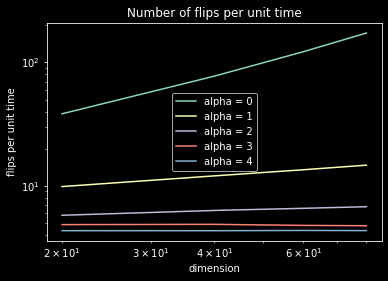

In [39]:
series = simulation_table[simulation_table[:,1]==0.0,:]
plt.loglog(series[:,0], series[:,4], label='alpha = 0')

series = simulation_table[simulation_table[:,1]==1.0,:]
plt.loglog(series[:,0], series[:,4], label='alpha = 1')

series = simulation_table[simulation_table[:,1]==2.0,:]
plt.loglog(series[:,0], series[:,4], label='alpha = 2')

series = simulation_table[simulation_table[:,1]==3.0,:]
plt.loglog(series[:,0], series[:,4], label='alpha = 3')

series = simulation_table[simulation_table[:,1]==4.0,:]
plt.loglog(series[:,0], series[:,4], label='alpha = 4')

plt.legend()
plt.xlabel("dimension")
plt.ylabel("flips per unit time")
plt.title("Number of flips per unit time")
#plt.show()
plt.savefig("figures/zz_ng_flips.png",dpi=199)

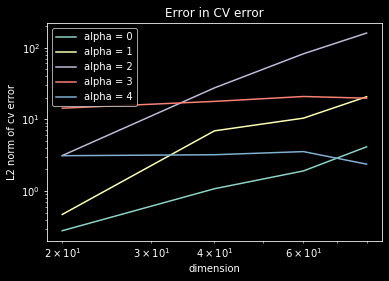

In [40]:
series = simulation_table[simulation_table[:,1]==0.0,:]
plt.loglog(series[:,0], series[:,3], label='alpha = 0')

series = simulation_table[simulation_table[:,1]==1.0,:]
plt.loglog(series[:,0], series[:,3], label='alpha = 1')

series = simulation_table[simulation_table[:,1]==2.0,:]
plt.loglog(series[:,0], series[:,3], label='alpha = 2')

series = simulation_table[simulation_table[:,1]==3.0,:]
plt.loglog(series[:,0], series[:,3], label='alpha = 3')

series = simulation_table[simulation_table[:,1]==4.0,:]
plt.loglog(series[:,0], series[:,3], label='alpha = 4')

plt.legend()

plt.xlabel("dimension")
plt.ylabel("L2 norm of cv error")
plt.title("Error in CV error")
#plt.show()
plt.savefig("figures/zz_ng_error_cv.png",dpi=199)

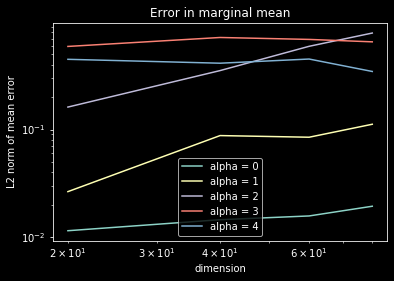

In [41]:
series = simulation_table[simulation_table[:,1]==0.0,:]
plt.loglog(series[:,0], series[:,2], label='alpha = 0')

series = simulation_table[simulation_table[:,1]==1.0,:]
plt.loglog(series[:,0], series[:,2], label='alpha = 1')

series = simulation_table[simulation_table[:,1]==2.0,:]
plt.loglog(series[:,0], series[:,2], label='alpha = 2')

series = simulation_table[simulation_table[:,1]==3.0,:]
plt.loglog(series[:,0], series[:,2], label='alpha = 3')

series = simulation_table[simulation_table[:,1]==4.0,:]
plt.loglog(series[:,0], series[:,2], label='alpha = 4')

plt.legend()

plt.xlabel("dimension")
plt.ylabel("L2 norm of mean error")
plt.title("Error in marginal mean")
#plt.show()
plt.savefig("figures/zz_ng_error_mean.png",dpi=199)